<a href="https://colab.research.google.com/github/rodmorx/DSP_DT_WS24/blob/main/NER_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title


In [1]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [9]:
import ast
import pandas as pd
import numpy as np
import spacy
from itertools import combinations
import string
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import datetime

# Importing the csv file

In [3]:
df = pd.read_csv('out_with_topic.csv')
df['date_publish'] = pd.to_datetime(df['date_publish'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Creating one big dataframe with every author and reading which one has created more articles

In [5]:
authors_df = pd.DataFrame(columns=['authors'])
for author_list in df["authors"]:
    new_pd = pd.DataFrame(ast.literal_eval(author_list), columns=['authors'])
    authors_df = pd.concat([authors_df, new_pd], ignore_index=True)
authors_df['authors'].value_counts()

authors
Bild               1138
Heiko Niedderer     176
David Verhoff       162
Joachim Schuth      138
Nico Linner         134
                   ... 
Marc Gruber           1
Yana Shabaeva         1
Inna Hemme            1
Johannes Berner       1
Alina Goldapp         1
Name: count, Length: 1090, dtype: int64

# For each article, get the entities associated

In [5]:
!python3 -m spacy download de_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 7.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')


In [6]:
!pip list

/home/sara/Documents/Appunti_uni/Projekt-Data Science/Aufgabe/DSP_DT_WS24/venv/bin/pip: 2: exec: /home/sara/Documents/Appunti_uni/Projekt-Data Science/Aufgabe/venv/bin/python3: not found


In [7]:
ner = spacy.load("de_core_news_md")

In [8]:
entities = []
entity_labels = ['GPE', 'ORG','PERSON']
for article in df['maintext'].head():
    text_ents = ner(article)
    entities.append({'maintext': article, 'ents' : [ent.text for ent in text_ents if ent.ent_type_ in entity_labels], 'authors': df['authors']})
entities_df = pd.DataFrame(entities)

In [39]:
print(entities_df.head())

                                            maintext  \
0  Stammplatz weg, ungewisse Zukunft. Sportlich l...   
1  Frohes Neues liebe BILDplus-User! Damit der St...   
2  Tennis-Start ins Neue Jahr! In Australien spie...   
3  Dieser Start in 2024 hat es in sich!\nHeute ha...   
4  Muss Europa JETZT drastisch aufrüsten?\nKreml-...   

                                                ents  \
0  [Sheffield, Wednesday, RB, Leipzig, FC, Chelse...   
1  [IHR, MEGA, MONTAG, BILDplus, Midnight, !, TEI...   
2  [Deutschland, Frankreich, Italien, DTB-Team, S...   
3  [FC, Bayern, FC, Basel, Hause, gegen, Hoffenhe...   
4  [JETZT, Militär, Universität, der, Bundeswehr,...   

                                             authors  
0  0                        ['Yvonne Gabriel']
1 ...  
1  0                        ['Yvonne Gabriel']
1 ...  
2  0                        ['Yvonne Gabriel']
1 ...  
3  0                        ['Yvonne Gabriel']
1 ...  
4  0                        ['Yvonne Gabriel']
1 ..

# Create a list of source and target entities, to make graphs with

In [ ]:


# Extract entity pairs from sentences
entity_pairs = []


for article in df['maintext'].head(): # we need to decide which articles to create the network analysis with
    doc = ner(article)
    for sent in doc.sents:
        sent_entities = [ent.text for ent in sent.ents]
        # Create all combinations of entities in the sentence
        entity_pairs += list(combinations(sent_entities, 2))


entity_pairs_df = pd.DataFrame(entity_pairs, columns=["source","target"])

          source        target
0     Dresdnerin   Dieses Jahr
1  Sara Gündogan   Anika Neuer
2  Sara Gündogan  Sophia Weber
3  Sara Gündogan   Kai Havertz
4    Anika Neuer  Sophia Weber


In [ ]:
%pip install networkx

In [ ]:
%pip install matplotlib

# Create a new dataframe out of the list and sort it, then add a weight to the graph
Which means that the weight of a node will be heavier the more times the relationship is mentioned 

In [12]:
entity_pairs_df = pd.DataFrame(np.sort(entity_pairs_df.values, axis = 1), columns = entity_pairs_df.columns)
entity_pairs_df["value"] = 1
entity_pairs_df = entity_pairs_df.groupby(["source","target"], sort=False, as_index=False).sum()

# Visualize the graph
First we create a networkx graph to visualize it

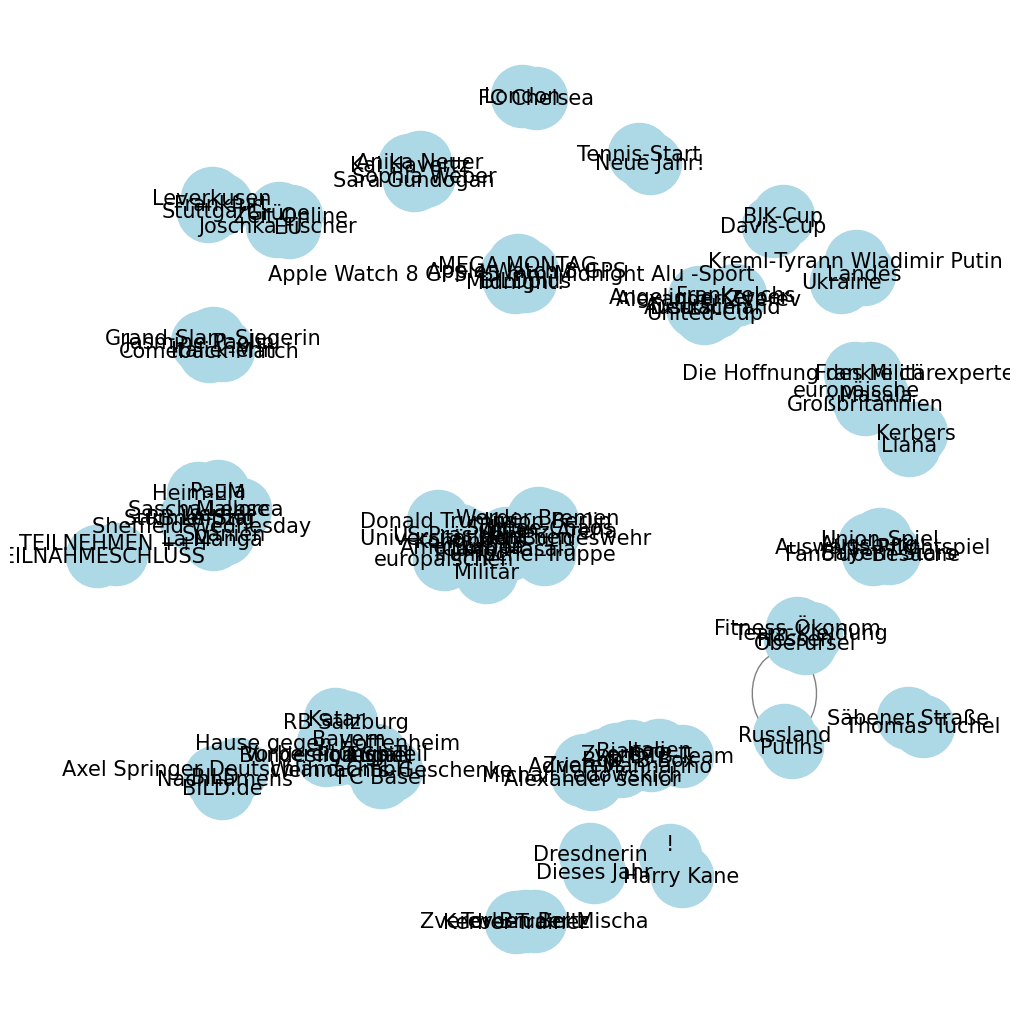

In [ ]:

# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(entity_pairs_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

# Add edges to the graph
G.add_edges_from(entity_pairs)

# Draw the network
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=15)
plt.show()

In [ ]:
%pip install pyvis

To visualize it better we use the pyvis library

In [ ]:

net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='remote', select_menu=True)

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("zeit.html")
net.save_graph("zeit_2.html")

zeit.html


In [7]:
def generate_network_graph(conditions):
    ner = spacy.load("de_core_news_md") #load german model

    # Extract entity pairs from sentences
    entity_pairs = []

    gen = df.loc[df.apply(conditions, axis=1), 'maintext']

    for article in gen: # we need to decide which articles to create the network analysis with
        doc = ner(article)
        for sent in doc.sents:
            sent_entities = [ent.text for ent in sent.ents]
            # Create all combinations of entities in the sentence
            entity_pairs += list(combinations(sent_entities, 2))


    entity_pairs_df = pd.DataFrame(entity_pairs, columns=["source","target"])
    entity_pairs_df = pd.DataFrame(np.sort(entity_pairs_df.values, axis = 1), columns = entity_pairs_df.columns)
    # let's add the value column so to add weight
    entity_pairs_df["value"] = 1
    entity_pairs_df = entity_pairs_df.groupby(["source","target"], sort=False, as_index=False).sum()

    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(entity_pairs_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())

    # Add edges to the graph
    G.add_edges_from(entity_pairs)

    net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='remote', select_menu=True)

    node_degree = dict(G.degree)

    #Setting up node size attribute
    nx.set_node_attributes(G, node_degree, 'size')

    net.from_nx(G)
    net.show("mygraph.html")
    net.save_graph("mygraph.html")

    # degree centrality, this will do a research on the topic that's most talked about

    degree_dict = nx.degree_centrality(G)
    degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
    degree_df.sort_values('centrality', ascending= False)[0:9].plot(kind="bar")

In [5]:
def get_network_by_author(author):
    conditions = lambda row: author in row['authors']
    generate_network_graph(conditions)

def get_network_by_date(date_from= None, date_to=None ):
    conditions = lambda row: date_from <= row['date_publish'] <= date_to
    generate_network_graph(conditions)

def extract_entities(article):
    doc = ner(article)  # Run the NER model
    sent_entities = []
    for sent in doc.sents:
        sent_entities.extend([ent.text for ent in sent.ents])  # Collect entities from each sentence
    return sent_entities

def get_network_by_topic(topic):
    conditions = lambda row: topic in row['topic']
    generate_network_graph(conditions)

def get_entity_over_time(entity):
    # Apply the function to the 'maintext' column and create a new column 'entities'
    df['entities'] = df['maintext'].apply(extract_entities)


    filtered_df = df[df['entities'].apply(lambda x: entity in x)]

    weekly_counts = (
    filtered_df
    .groupby(pd.Grouper(key='date_publish', freq='W'))  # Group by weeks
    .size()
    )

    # Plot the data
    plt.figure(figsize=(10, 6))
    weekly_counts.plot(kind='line', marker='o', label=entity, color='blue')


    # Add labels and title
    plt.title(f"Occurrences of {entity} Over Time", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.grid(True)
    plt.legend()

    return filtered_df

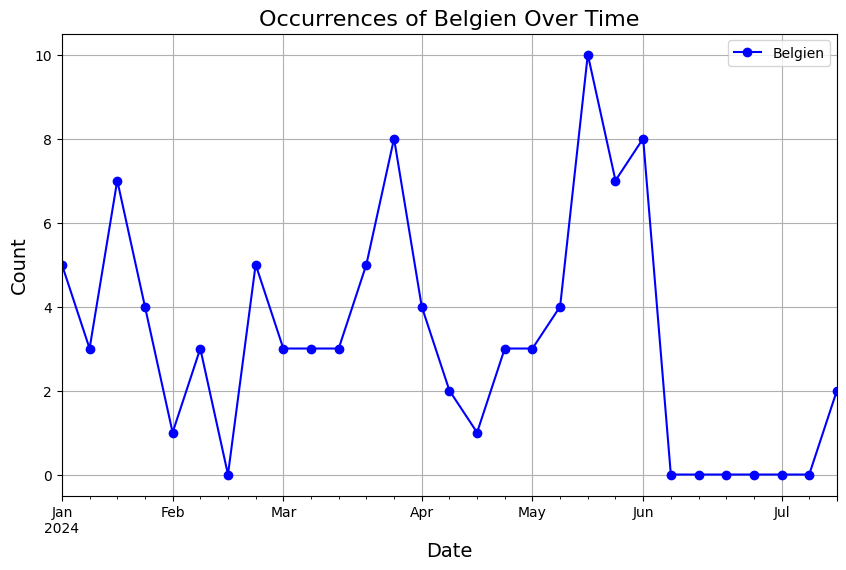

In [73]:
get_entity_over_time('Belgien')

mygraph.html


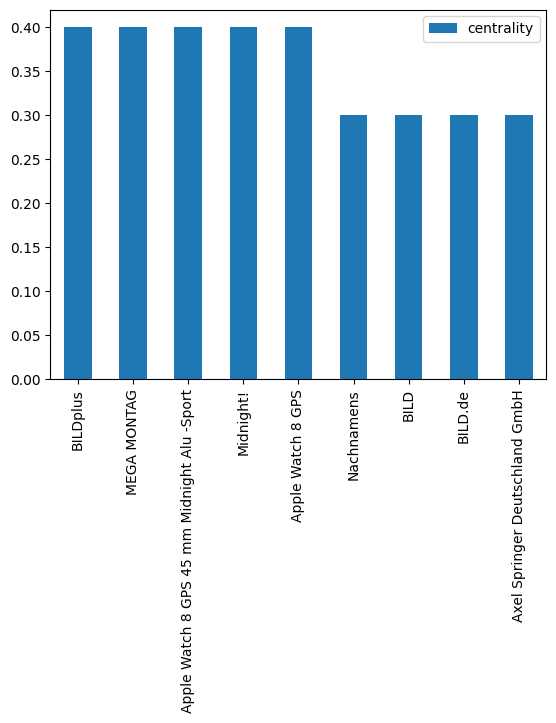

In [11]:
get_network_by_topic('sport')